### Dependencies
This assumes you have `pandas`, `numpy`, `jupyterlab`, `plotly`, `scikit-optimize`, and `pandas-ta` available in your system or virtual environment. 
You also need `ta-lib`, on macOS you can get it with `brew install ta-lib`

### Configuration
Create a file called `.env` with:
```env
EXCHG_API_KEY=d019f019ca0918c0ac80
EXCHG_SECRET=ba19ca9310de910
```

In [30]:
import sys
# install dependencies
!{sys.executable} -m pip install -q matplotlib ipywidgets plotly pyjuque

ERROR: Could not find a version that satisfies the requirement sciki (from versions: none)
ERROR: No matching distribution found for sciki
You should consider upgrading via the '/Users/cyber/Library/Caches/pypoetry/virtualenvs/trader-s5F4ixgX-py3.9/bin/python -m pip install --upgrade pip' command.
  Cloning https://github.com/revmischa/pyjuque (to revision patch-1) to /private/var/folders/kd/1xqhjdy16c31k9ffswc8wbm40000gn/T/pip-req-build-ft6fqcpd
  Running command git clone -q https://github.com/revmischa/pyjuque /private/var/folders/kd/1xqhjdy16c31k9ffswc8wbm40000gn/T/pip-req-build-ft6fqcpd
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/Users/cyber/Library/Caches/pypoetry/virtualenvs/trader-s5F4ixgX-py3.9/bin/python -m pip install --upgrade pip' command.


In [225]:
import time
import os
from pprint import pprint
import logging
import cProfile
from typing import Dict
import datetime
import math
from IPython.display import HTML
from copy import deepcopy
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import pandas_ta as ta
import skopt.plots as skplots
import sklearn.dummy
from skopt.plots import plot_evaluations
from skopt import gp_minimize, forest_minimize, dummy_minimize, BayesSearchCV
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import Optimizer
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import plotly

from pyjuque.Bot import defineBot
from pyjuque.Plotting import PlotData, GetPlotData
from pyjuque.Exchanges.CcxtExchange import CcxtExchange
from pyjuque.Engine.BacktesterSundayTheQuant import Backtester
from pyjuque.Strategies import StrategyTemplate

%matplotlib inline
%%capture stored_output

# connect to your exchange
exchange = CcxtExchange("ftx")

UsageError: Line magic function `%%capture` not found.


In [ ]:
timeframe = '15s'  # 1 minute timeframe
starting_balance = 1000. # dollars
symbol = 'ETH-PERP'

# configure your exchange here via .env file
load_dotenv()
api_key = os.environ["EXCHG_API_KEY"]
secret = os.environ["EXCHG_SECRET"]
exchange_config = {
    "exchange": {
        "name": "ftx",
        "params": {
            "api_key": api_key,
            "secret": secret,
        },
    },
}

def gen_config(
    StratClass,
    signal_distance,
    take_profit,
    stop_loss_value,
    test_run=True,
    params: Dict[str, float]=None,
) -> dict:
    if not params:
        params = {}
    return {
        "name": "simulator",
        "test_run": test_run,
        **exchange_config,
        "symbols": [ symbol ],
        "starting_balance": starting_balance,
        "strategy": {"class": StratClass, "params": params},
        "timeframe": timeframe,
        "entry_settings": {
            "initial_entry_allocation": 5,
            "signal_distance": signal_distance,  # pct under buy signal to place order
            "leverage": 1,
        },
        "exit_settings": {
            "take_profit": take_profit,
            "stop_loss_value": stop_loss_value,
            "exit_on_signal": True,
            "sell_on_end": True,
        },
    }


In [231]:
# how many units of timeframe (15s) to test back in time
backtest_times = 4 * 60 * 24 * 1#days
#backtest_times = 4 * 60 * 12#hours

# utilities
symbol_df_cache: Dict[str, pd.DataFrame] = {
    symbol: exchange.getOHLCV(symbol, timeframe, backtest_times)
}


def backtest(bot_config: dict) -> Backtester:
    bt = Backtester(bot_config)
    results = {}
    for symbol in bot_config["symbols"]:
        # fetch historical exchange data (OHLCV) for symbol
        # backtesting will be performed on this dataset
        if not symbol in symbol_df_cache:
            symbol_df_cache[symbol] = exchange.getOHLCV(symbol, bot_config['timeframe'], backtest_times)
        df = symbol_df_cache[symbol]

        # backtest
        bt.backtest(df)
        results[symbol] = dict(results=bt.return_results(), entries=bt.entries, exits=bt.exits, df=df)
        
    return results

def plot_backtest_results(title, df, entries, exits):
    return PlotData(df, 
        plot_indicators=[
            dict(name = 'slow_ma', title = 'Slow HMA'),
            dict(name = 'fast_ma', title = 'Fast HMA'),
        ],
        signals=[
            dict(name = 'Buy', points = entries), 
            dict(name = 'Sell', points = exits),
        ], 
        add_volume=False,
        plot_title=title,
    )

In [232]:
# strategy to run
class EMACross(StrategyTemplate):
    """Bollinger Bands x RSI"""

    minimum_period = 100

    def __init__(self, fast_ma_len=5, slow_ma_len=15):
        self.fast_ma_len = fast_ma_len
        self.slow_ma_len = slow_ma_len
        # the minimum number of candles needed to compute our indicators
        self.minimum_period = max(60, slow_ma_len)

    # the bot will call this function with the latest data from the exchange
    # passed through df; this function computes all the indicators needed
    # for the signal
    def setUp(self, df):
        df["slow_ma"] = ta.ema(df["close"], self.slow_ma_len)
        df["fast_ma"] = ta.ema(df["close"], self.fast_ma_len)
        self.dataframe = df

    # the bot will call this function with the latest data and if this
    # returns true, our bot will place an order
    def checkLongSignal(self, i=None):
        """ """
        df = self.dataframe
        if i == None:
            i = len(df) - 1
        if i < 1:
            return False
        if (
            df["low"][i - 1] < df["slow_ma"][i - 1]
            and df["low"][i] > df["slow_ma"][i]
            and df["low"][i] > df["fast_ma"][i]
            and df["fast_ma"][i] > df["slow_ma"][i]
        ):
            return True
        return False

    def checkShortSignal(self, i=None):
        df = self.dataframe
        if i == None:
            i = len(df) - 1
        if i < 1:
            return False
        if (
            (
                df["low"][i - 1] > df["slow_ma"][i - 1]
                or df["fast_ma"][i - 1] > df["slow_ma"][i - 1]
            )
            and df["close"][i] < df["slow_ma"][i]
            and df["close"][i] < df["fast_ma"][i]
            and df["fast_ma"][i] < df["slow_ma"][i]
        ):
            return True
        return False

In [233]:
# search space
fast_ma_len = Real(name='fast_ma_len', low=3.0, high=12.0)
slow_ma_len = Real(name='slow_ma_len', low=12.0, high=40.0)
# number between 0 and 100 - 1% means that when we get a buy signal, 
# we place buy order 1% below current price. if 0, we place a market 
# order immediately upon receiving signal
signal_distance = Real(name='signal_distance', low=0.0, high=1.0)
# take profit value between 0 and infinity, 3% means we place our sell 
# orders 3% above the prices that our buy orders filled at
take_profit = Real(name='take_profit', low=0.01, high=1.0)
stop_loss_value = Real(name='stop_loss_value', low=1, high=50.0)
dimensions = [fast_ma_len, slow_ma_len, signal_distance, take_profit, stop_loss_value]

def calc_strat_loss(backtest_res) -> dict:
    """Given backtest results, calculate loss.
    
    Loss is a measure of how badly we're doing.
    """
    score = 0
    
    for symbol, symbol_res in backtest_res.items():
        symbol_bt_res = symbol_res['results']
        profit_realised = symbol_bt_res['profit_realised']
        profit_after_fees = symbol_bt_res['profit_after_fees']
        winrate = symbol_bt_res['winrate']

        if profit_after_fees < 0:
            # lost money.
            # bad.
            score -= profit_after_fees + 1

        if profit_after_fees == 0.0:
            # well it's not great but not terrible...
            pass

        # how well we're doing (positive)
        score += profit_after_fees# + winrate/100
        
    if score < 0:
        # not doing so good
        return -1 * score

    # return loss; lower number is better
    return math.pow(0.99, score)

def params_to_bot_config(p):
    params = {**p}
    # strat params
    fast_ma_len = params.pop('fast_ma_len', None)
    slow_ma_len = params.pop('slow_ma_len', None)
    bot_config = gen_config(
        StratClass=EMACross, 
        #params=dict(fast_ma_len=fast_ma_len, slow_ma_len=slow_ma_len),
        **params
    )
    return bot_config

In [ ]:
@use_named_args(dimensions=dimensions)
def objective(**params):
    """This is our fitness function.
    
    It takes a set of parameters and returns the "loss" - an objective single scalar to minimize.
    """
    profile = True
    
    if profile:
        pr = cProfile.Profile()
        pr.enable()

    bot_config = params_to_bot_config(params)
    
    try:
        backtest_res = backtest(bot_config)
    except Exception as ex:
        print(ex)
        if 'Not enough data' in str(ex) or 'TA_BAD_PARAM' in str(ex):
            return 1  # bad input
        raise ex
    finally:
        if profile:
            pr.disable()
            pr.dump_stats('objective')

    return calc_strat_loss(backtest_res)

def opt_ema_strat_sk(n_calls) -> Dict[str, float]:
    start_time = time.time()
    opt_res = forest_minimize(func=objective,
                          dimensions=dimensions,
                          n_calls=n_calls, base_estimator="ET",
                          random_state=None)
    elapsed = time.time() - start_time
    print(f"{n_calls} calls, elapsed={elapsed:0.2f}s, rate={n_calls/elapsed:0.1f} calls/s")
    return opt_res

optimizer = Optimizer(
    dimensions=dimensions,
    random_state=None,  # random seed
    #base_estimator=sklearn.dummy.DummyRegressor()
)

PROFILING = False
def opt_ema_strat_sk_parallel(n_calls:int) -> Optimizer:
    start_time = time.time()
    if PROFILING:
        pr = cProfile.Profile()
        pr.enable()

    parallel = 4
    for i in range(int(n_calls / parallel)):
        x = optimizer.ask(n_points=parallel)  # x is a list of n_points points
        if i % 10 == 0:
            print(f"Grabbing @ {i*parallel}...")
        y = Parallel(n_jobs=parallel)(delayed(objective)(v) for v in x)  # evaluate points in parallel
        optimizer.tell(x, y)
        
    if PROFILING:
        pr.disable()
        pr.dump_stats('profile')
    elapsed = time.time() - start_time
    print(f"{n_calls} calls, elapsed={elapsed:0.2f}s, rate={n_calls/elapsed:0.1f} calls/s")
        
    return optimizer

In [237]:
optimizer = opt_ema_strat_sk_parallel(n_calls=30)
#best_opt_result = opt_ema_strat_sk(n_calls=30)

Grabbing @ 0...
30 calls, elapsed=26.53s, rate=1.1 calls/s


In [238]:
# find best
min_loss = 1.0
best_params = None
for i, x in enumerate(optimizer.Xi):
    loss = optimizer.yi[i]
    if loss < min_loss:
        min_loss = loss
        best_params = x
print("Best:", min_loss)
print("Best parameters:", best_params)
best_config = dict(zip([d.name for d in dimensions], best_params))
print(best_config)

Best: 0.9747846126155418
Best parameters: [8.499027527246923, 12.15681832197789, 0.770654562278189, 0.5468829722967068, 28.052139662333495]
{'fast_ma_len': 8.499027527246923, 'slow_ma_len': 12.15681832197789, 'signal_distance': 0.770654562278189, 'take_profit': 0.5468829722967068, 'stop_loss_value': 28.052139662333495}


In [239]:
#best_config = dict(zip([d.name for d in dimensions], best_opt_result.x))
#pprint(best_config)

{'fast_ma_len': 3.085784034012965,
 'signal_distance': 0.30483843513412284,
 'slow_ma_len': 26.390396510562866,
 'stop_loss_value': 47.7818901677924,
 'take_profit': 0.23350167308127126}


In [240]:
best_config = params_to_bot_config(best_config)
bt_res = backtest(best_config)

In [241]:
alloc = best_config['entry_settings']['initial_entry_allocation']
entry_exit_marker_size = 15
def fix_series_ts(initial_entry_allocation: float, series:list[tuple]):
    ret = []
    for e in series:
        n = [*e]
        n[0] = pd.to_datetime(n[0] * 10e5)
        n[2] = entry_exit_marker_size
        ret.append(n)
    return ret

# formatting and massaging results
symbol_bt_res = bt_res[symbol]
res = symbol_bt_res['results']
print(res)
profit = res['profit_after_fees']
initial = res['balance_initial']
bal = res['balance_plus_profits']
print(f"{symbol}: Initial {initial}, profit: {profit:0.3}, return %{(bal/float(initial)*100):.6}")
df = symbol_bt_res['df']

# visualize trades made during backtesting
# date and time columns are broken
df2 = df.drop(columns=['date'])
df2['time'] = pd.to_datetime(df['time'] * 10e5)
# generate plotly figure
fig = plot_backtest_results(
    symbol, 
    df2, 
    fix_series_ts(alloc, symbol_bt_res['entries']), 
    fix_series_ts(alloc, symbol_bt_res['exits'])
)

# will render inline a nice visualization of buy/sell events on a candlestick chart
fig

{'balance_initial': 1000.0, 'balance_locked': 0.0, 'balance_free': 1000.0, 'balance_plus_profits': 1002.5912914037987, 'profit': 2.5912914037986483, 'profit_realised': 2.5912914037986483, 'profit_unrealised': 0.0, 'profit_buy_and_hold': -1.7428609733207168, 'profit_after_fees': 2.5911167021756687, 'n_trades': 251, 'n_long': 136, 'n_shorts': 0, 'n_locked_trades': 0, 'n_profitable_trades': 45, 'n_losing_trades': 70, 'winrate': 0.391304347826087}
ETH-PERP: Initial 1000.0, profit: 2.59, return %100.259


FigureWidget({
    'data': [{'close': array([3729.5, 3719.5, 3715.2, ..., 3721.3, 3723.7, 3723. ]),
          …

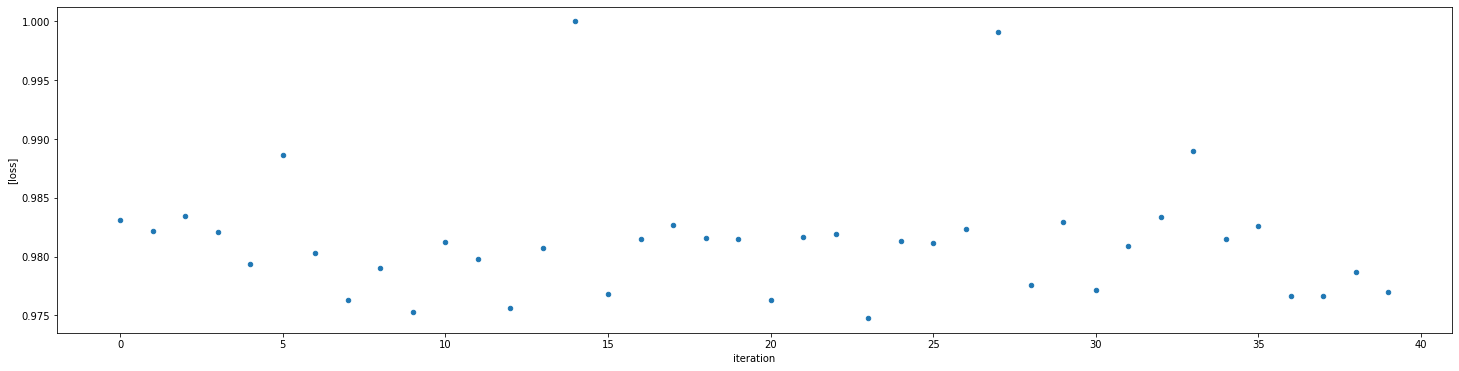

In [242]:
# trials w/ results
btdf = pd.DataFrame({
    'loss': optimizer.yi, 
    'iteration': range(len(optimizer.yi)),
})
btdf['l'] = btdf['loss']
fig = btdf.plot.scatter('iteration', y=['loss'], logy=False, figsize=(25,6))

<AxesSubplot:xlabel='signal_distance', ylabel='take_profit'>

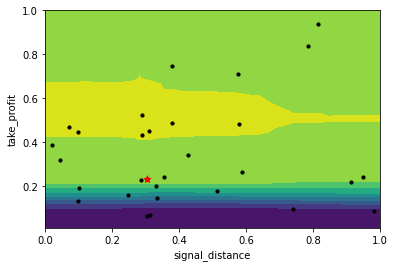

In [243]:
skplots.plot_objective_2D(best_opt_result, dimension_identifier1='signal_distance', dimension_identifier2='take_profit')

<AxesSubplot:xlabel='signal_distance', ylabel='stop_loss_value'>

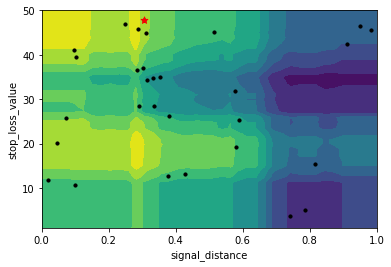

In [247]:
skplots.plot_objective_2D(best_opt_result, dimension_identifier1='signal_distance', dimension_identifier2='stop_loss_value')

<AxesSubplot:xlabel='stop_loss_value', ylabel='take_profit'>

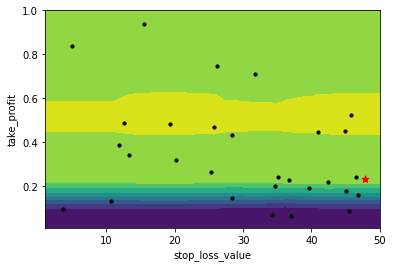

In [245]:
skplots.plot_objective_2D(best_opt_result, dimension_identifier1='stop_loss_value', dimension_identifier2='take_profit')

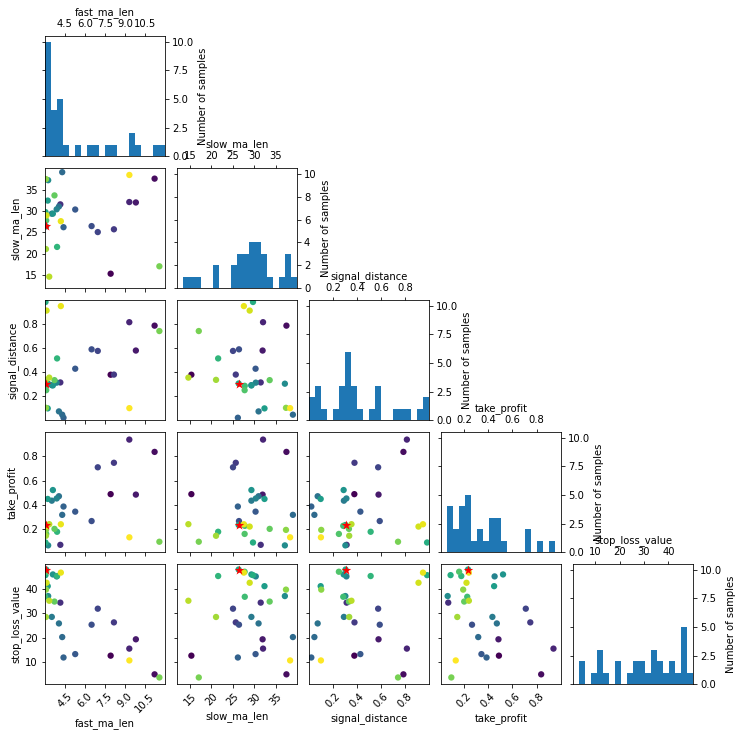

In [246]:
_ = skplots.plot_evaluations(best_opt_result)

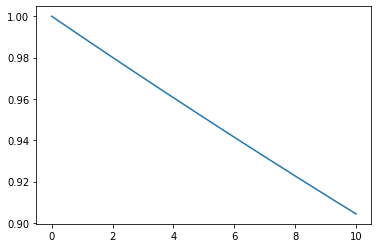

In [224]:
x = np.linspace(0,10,1000)

fig, ax = plt.subplots()
ax.plot(x, np.power(0.99, x))
plt.show()